In [1]:
!pip install --upgrade apafib

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for apafib: filename=apafib-0.2.15-py3-none-any.whl size=20112 sha256=e97635f7ab90113641fa652765e5286c1489cd1f0baccc72b4b0f381c6b65c2f
  Stored in directory: /root/.cache/pip/wheels/3d/de/ef/ac7fda04a364806257a92a993d632076cee2e6774dbc0c5929
Successfully built apafib


## Exploración del conjunto de datos

In [2]:
from apafib import load_medical_costs
import pandas as pd
from sklearn.model_selection import train_test_split


df = load_medical_costs()
df.head()


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
df.isna().sum()

,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


<Axes: >

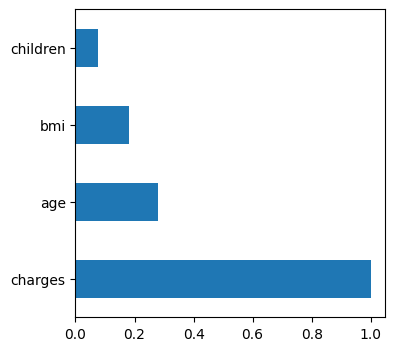

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# División 70% entrenamiento 30% test
#train_df, test_df = train_test_split(df, test_size=0.3, random_state=0)

X = df.loc[:,df.columns != 'charges']
y = df['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

train_df = X_train.copy()
train_df['charges'] = y_train

#correlacion charges con variables numericas
colCharges = [col for col in train_df.columns if "charges" in col][0]
correlacion = train_df.corr(numeric_only=True)
corrCharges = correlacion[colCharges].sort_values(ascending = False)
plt.figure(figsize=(4,4))
corrCharges.plot(kind='barh')

En la gráfica se puede observar la correlación de la variable objetivo, *charges* junto con las variables numéricas presentes en el conjunto de  entrenamiento de la base de datos df.
Se observa que la correlación más alta con *charges* se da con la propia edad (*age*), lo que indica que la edad es el factor numérico con mayor impacto en el coste del seguro médico. El índice de masa corporal (*bmi*) presenta una menor correlación. Por último, el número de hijos (*children*) muestra una correlación muy baja con el coste, por tanto esta variable apenas influye de forma directa en el precio del seguro.

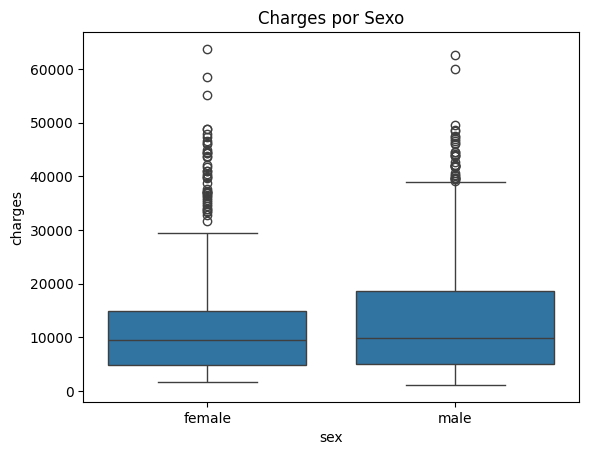

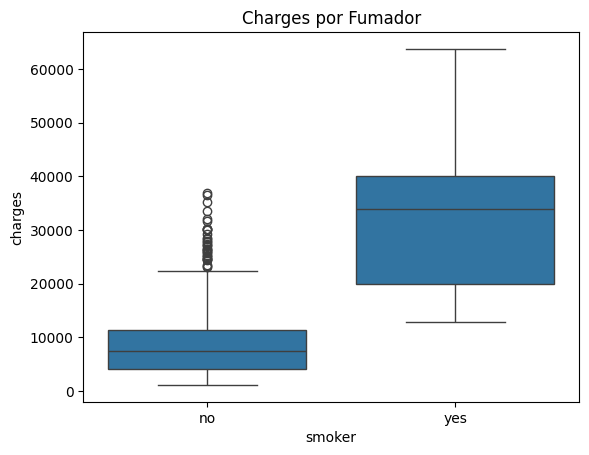

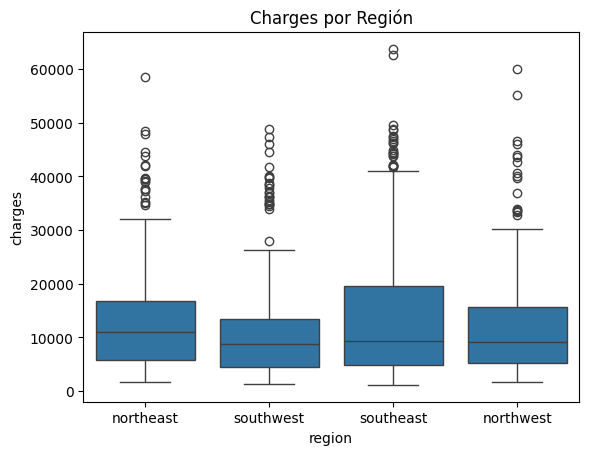

In [5]:

# Relación entre sexo y charges
sns.boxplot(x='sex', y='charges', data=train_df)
plt.title('Charges por Sexo')
plt.show()

# Relación entre fumador y charges
sns.boxplot(x='smoker', y='charges', data=train_df)
plt.title('Charges por Fumador')
plt.show()

# Relación entre región y charges
sns.boxplot(x='region', y='charges', data=train_df)
plt.title('Charges por Región')
plt.show()



Exploración visual de las relaciones entre variables categóricas y el coste del seguro (*charges*)

**Charges por Sexo:**  
El boxplot que compara el coste por sexo muestra que tanto hombres como mujeres presentan distribuciones similares en los cargos, con medianas y rangos muy parecidos. Por lo que el sexo no parece influir de manera importante en el coste del seguro médico.

**Charges por Fumador:**  
En el gráfico de boxplot según el hábito de fumar, se observa una diferencia muy marcada entre fumadores y no fumadores. Los fumadores tienen cargos significativamente más altos, con una mediana mucho mayor y una mayor dispersión. Este resultado indica que el hábito de fumar es uno de los factores más relevantes para el coste del seguro.

**Charges por Región:**  
Las medianas y rangos de los cargos son comparables entre regiones, lo que sugiere que la ubicación geográfica tiene un impacto limitado en el coste del seguro médico.

---

En resumen, la exploración visual evidencia que las variables que muestran una mayor relación con el coste del seguro son la edad y, especialmente, el hecho de ser fumador. El número de hijos, el sexo y la región parecen tener un impacto mucho menor.

## PCA

PCA se basa en la matriz de covarianza de las variables, por lo que antes de aplicar PCA es necesario que todas las variables estén estandarizadas y en formato numérico. Por ello, primero estandarizamos las variables numéricas (*age*, *bmi*, *children*) y codificamos las categóricas (*smoker*, *sex*, *region*) usando OneHotEncoder.


In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

train_prepared = train_df.copy()

num_features = ['age', 'bmi', 'children']
cat_features = ['smoker', 'sex', 'region']

# Estandariza variables numéricas
train_prepared[num_features] = StandardScaler().fit_transform(X_train[num_features])

# Encoder solo a las categóricas
encoder = OneHotEncoder(drop='first', sparse_output=False)
cat_encoded = encoder.fit_transform(X_train[cat_features])

cat_encoded_names = encoder.get_feature_names_out(cat_features)

cat_encoded_df = pd.DataFrame(cat_encoded, columns=cat_encoded_names, index=X_train.index)

# Añadimos las columnas codificadas al DataFrame estandarizado
train_prepared = pd.concat([train_prepared.drop(columns=cat_features), cat_encoded_df], axis=1)
train_prepared.describe().T

,count,mean,std,min,25%,50%,75%,max
age,936.0,-4.554761e-17,1.000535,-1.533097,-0.890473,0.037761,0.894593,1.751425
bmi,936.0,-5.285421e-16,1.000535,-2.373517,-0.698361,-0.071782,0.649465,3.590616
children,936.0,6.832142e-17,1.000535,-0.898339,-0.898339,-0.067464,0.763410,3.256034
charges,936.0,1.323292e+04,11880.110295,1121.873900,4908.794762,9575.442100,16687.364100,63770.428010
smoker_yes,936.0,2.029915e-01,0.402441,0.000000,0.000000,0.000000,0.000000,1.000000
sex_male,936.0,4.882479e-01,0.500129,0.000000,0.000000,0.000000,1.000000,1.000000
region_northwest,936.0,2.393162e-01,0.426894,0.000000,0.000000,0.000000,0.000000,1.000000
region_southeast,936.0,2.767094e-01,0.447611,0.000000,0.000000,0.000000,1.000000,1.000000
region_southwest,936.0,2.532051e-01,0.435080,0.000000,0.000000,0.000000,1.000000,1.000000


El método PCA de scikit-learn devuelve la relación de varianza explicada y otros parámetros importantes. Se puede usar la relación de varianza explicada y los valores singulares para decidir cuántos componentes conservar.

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

myPCA = PCA().fit(train_prepared.drop(columns=['charges']))


print(myPCA.explained_variance_ratio_)
print(myPCA.explained_variance_ratio_.cumsum())

[0.28806408 0.25017123 0.22287856 0.06567606 0.06207602 0.05770918
 0.03889077 0.01453411]
[0.28806408 0.53823531 0.76111386 0.82678992 0.88886594 0.94657513
 0.98546589 1.        ]


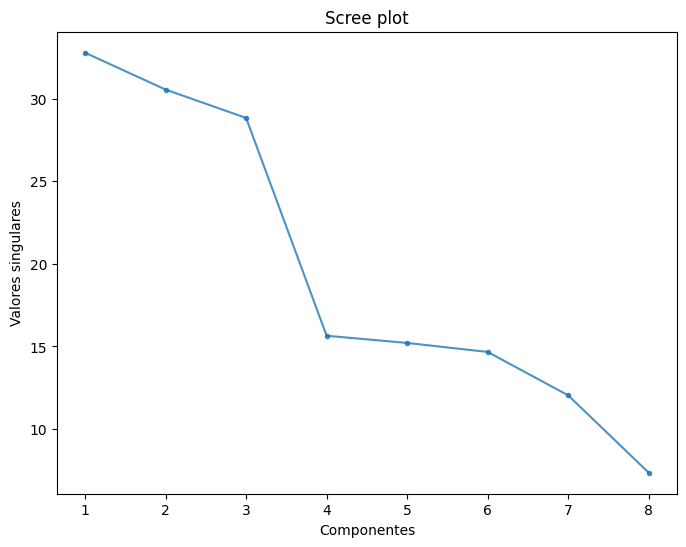

In [8]:
# Scree plot: valores singulares
fig = plt.figure(figsize=(8,6))
plt.plot(range(1, len(myPCA.singular_values_ )+1), myPCA.singular_values_, alpha=0.8, marker='.')
plt.ylabel('Valores singulares')
plt.xlabel('Componentes')
plt.title('Scree plot')
plt.show()


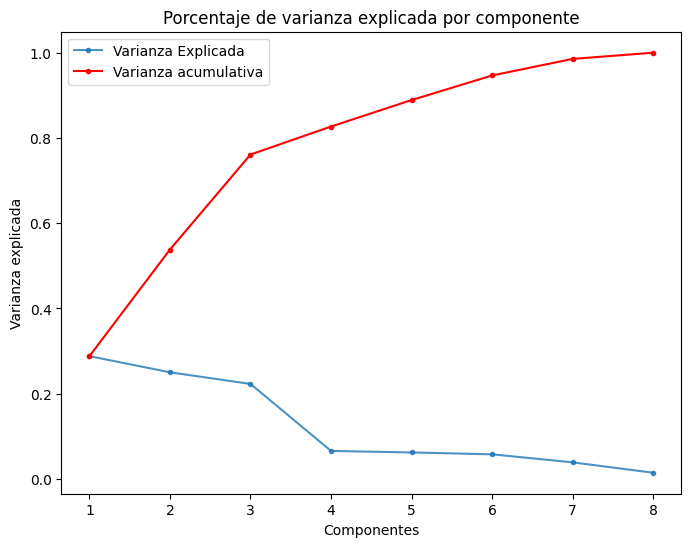

In [9]:
# Gráfica de varianza
plt.figure(figsize=(8,6))
plt.plot(range(1, len(myPCA.explained_variance_ratio_ )+1), myPCA.explained_variance_ratio_, alpha=0.8, marker='.', label="Varianza Explicada")
plt.plot(range(1, len(myPCA.explained_variance_ratio_ )+1), np.cumsum(myPCA.explained_variance_ratio_), c='red', marker='.', label="Varianza acumulativa")
plt.ylabel('Varianza explicada')
plt.xlabel('Componentes')
plt.legend()
plt.title('Porcentaje de varianza explicada por componente')
plt.show()

**Explicación de los gráficos resultante**

En el primer gráfico (Scree plot), se observa que los tres primeros componentes principales tienen valores singulares significativamente más altos que el resto. Esto indica que la mayor parte de la información relevante de este dataset se concentra en estos primeros componentes. A partir del cuarto componente, el aporte de varianza de cada nuevo componente disminuye considerablemente.

En el segundo gráfico, la línea azul representa la varianza explicada individualmente por cada componente, mientras que la línea roja muestra la varianza acumulada. Con los tres primeros componentes se acumula cerca del 80% de la varianza total del conjunto de datos, y casi toda la información relevante está contenida en los primeros cinco componentes.

Por tanto, para reducir la dimensionalidad y simplificar el análisis sin perder información importante, conservaremos los primeros tres componentes principales.

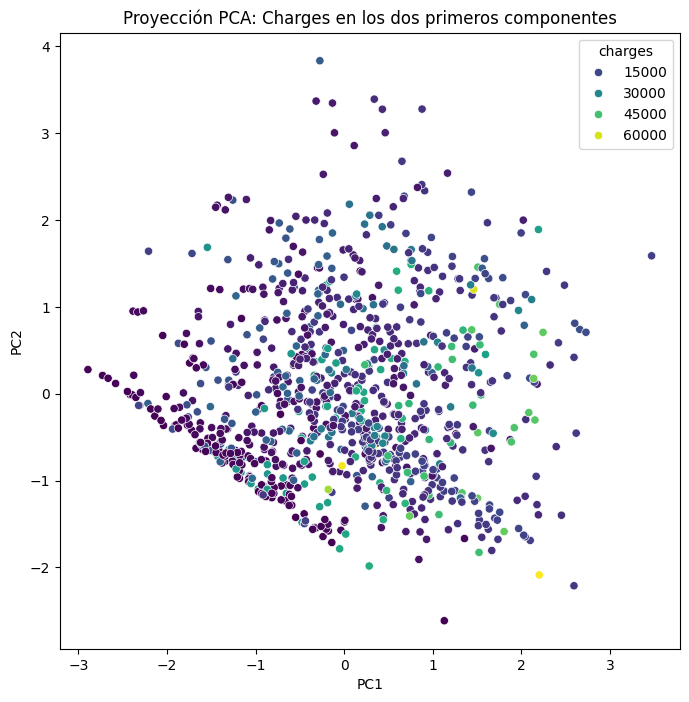

In [10]:
for col in ['PC1', 'PC2', 'PC3']:
    if col in train_prepared.columns:
        train_prepared = train_prepared.drop(columns=[col])

predictor_cols = train_prepared.columns.drop('charges')

pca_data = myPCA.transform(train_prepared[predictor_cols])

train_prepared[['PC1', 'PC2', 'PC3']] = pca_data[:, :3]

import seaborn as sns
fig = plt.figure(figsize=(8,8))
_ = sns.scatterplot(x='PC1', y='PC2', hue=train_prepared['charges'], data=train_prepared, palette='viridis')
plt.title('Proyección PCA: Charges en los dos primeros componentes')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Este gráfico facilita la visualización de la relación entre las características principales del dataset y el coste del seguro ("charges"). La dispersión de los puntos y la distribución de los colores permiten detectar posibles patrones o agrupaciones en los datos, ayudando a identificar si existen perfiles concretos asociados a seguros más elevados.

No se aprecia un agrupamiento muy marcado, pero sí se observa que los clientes con mayores "charges" no se distribuyen de forma homogénea en el espacio de los componentes principales. Esto indica que el coste del seguro está influido por ciertas combinaciones de características del cliente.

Si los valores altos de "charges" estuvieran repartidos de manera uniforme, significaría que el coste del seguro no depende de las características del cliente, sino que es aleatorio. Sin embargo, al observar puntos de color amarillo (costes altos) concentrados en ciertas zonas del gráfico, se sugiere la existencia de perfiles de riesgo o clientes particulares que tienden a tener seguros más caros debido a sus atributos.

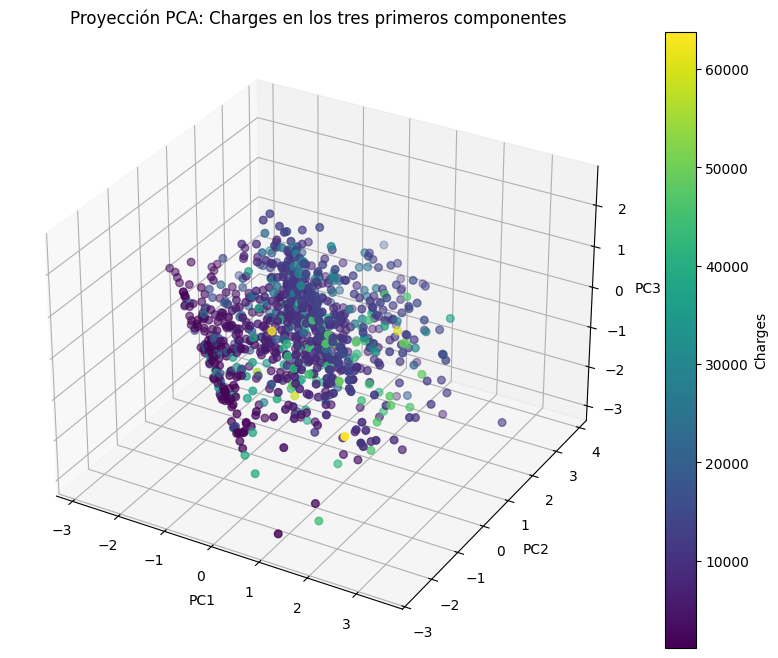

In [11]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(train_prepared['PC1'], train_prepared['PC2'], train_prepared['PC3'],
                c=train_prepared['charges'], cmap='viridis', s=30)
plt.colorbar(sc, label='Charges')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('Proyección PCA: Charges en los tres primeros componentes')
plt.show()


Este gráfico tridimensional muestra la distribución de los datos proyectados sobre los tres primeros componentes principales (PC1, PC2 y PC3) del Análisis de Componentes Principales (PCA).
Este gráfico refuerza la idea de que el coste del seguro depende de la relación entre varias variables, y que los perfiles de riesgo pueden identificarse mejor usando una representación multidimensional.

# Regresión lineal

In [12]:
from sklearn.model_selection import train_test_split,  KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import set_config

from yellowbrick.regressor import AlphaSelection
from yellowbrick.regressor.alphas import alphas
from statsmodels.genmod.generalized_linear_model import GLM
import statsmodels.api as sm
from scipy import stats

import warnings

In [13]:
def minimum_preprocessing(X, y):
    categorical_columns = X.dtypes[X.dtypes == 'category'].index.values
    # Eliminamos variables categoricas
    X = X.drop(columns=categorical_columns)
    print('Eliminadas: {}'.format(categorical_columns))
    # Eliminamos valores perdidos
    X = X.dropna()
    y = y[X.index]
    print('Nuevo tamaño:{}'.format(X.shape))
    return X, y

X_train, y_train = minimum_preprocessing(X_train, y_train)
X_test, y_test = minimum_preprocessing(X_test, y_test)



Eliminadas: []
Nuevo tamaño:(936, 6)
Eliminadas: []
Nuevo tamaño:(402, 6)


Aplicaremos por separado nuestro preprocesamiento a nuestras particiones de entrenamiento y prueba. Como se puede observar no se hace nada en los datos de tests que dependan de los de entrenamiento

### Scikit-learn

Todos los modelos de scikit-learn están implementados en clases con la misma estructura, por lo que al conocer uno, se conocen todos.

In [14]:
X_train_encoded = pd.get_dummies(X_train, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, drop_first=True)

X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

lr = LinearRegression()
lr.fit(X_train_encoded, y_train)
y_pred_train = lr.predict(X_train_encoded)

In [15]:
weights = lr.coef_
intercept = lr.intercept_
# Podemos acceder a información del modelo, como los pesos.
print('Coeficientes: \n', weights[:10])
print('Interceptor: \n', intercept)

Coeficientes: 
 [  256.43544682   335.36907276   472.70978916   -47.54675517
 23435.99116948  -561.90114536  -994.74867954  -799.44893726]
Interceptor: 
 -11835.309682878767


### Estimación de la calidad de regresión

#### MSE


In [16]:
from sklearn.metrics import mean_squared_error, r2_score

mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

print(f"Error cuadrático medio (MSE) en entrenamiento: {mse_train:.2f}")
print(f"Coeficiente de determinación (R²) en entrenamiento: {r2_train:.3f}")

Error cuadrático medio (MSE) en entrenamiento: 37931360.96
Coeficiente de determinación (R²) en entrenamiento: 0.731


Después de aplicar la regresión lineal y calcular el MSE y el coeficiente de determinación (R²), obtenemos que el modelo explica aproximadamente el 73% de la variabilidad de la variable objetivo en los datos de entrenamiento.

#### Normalized Mean Squared Error

In [17]:
N = X_train.shape[0]
norm_mse = np.sum((y_train - y_pred_train)**2)/((N)*np.var(y_train))

# Se puede usar la implementacion de R^2 de para calcular este valor
norm_mse_sk = 1-r2_score(y_train,y_pred_train)

norm_mse, norm_mse_sk

(np.float64(0.2690430128825298), 0.26904301288252985)

Cuando dividimos el error cuadrático medio por la varianza de los objetivos t, obtenemos la proporción de la variabilidad del objetivo que NO es explicada por el modelo.
En nuestro caso se obtiene un valor cercano al 0,2 lo cual es bueno, ya que los los modelos con 'norm.mse' por debajo de 0.2 son bastante buenos.

#### R-squared (R²)

In [18]:
R_squared = (1 - norm_mse)

# También se puede usar la implementacion de scikit-learn
R_squared_sk = r2_score(y_train,y_pred_train)

R_squared, R_squared_sk

(np.float64(0.7309569871174701), 0.7309569871174701)

#### Mean Absolute Error (MAE)

In [19]:
mae =  np.sum(np.abs(y_train - y_pred_train))/N

# Se puede usar la implementacion de MAE de para calcular este valor
mae_sk = mean_absolute_error(y_train,y_pred_train)

mae, mae_sk

(np.float64(4246.66101891283), 4246.66101891283)

In [20]:
mediana_charges = df["charges"].median()
print(f"La mediana de 'charges' es: {mediana_charges:.2f}")


La mediana de 'charges' es: 9382.03


El mejor resultado posible sería obtener un MAE de 0. En este caso el valor obtenido ha sido aproximadamente 4247. Esto significa que, en promedio, la predicción del modelo se desvía del valor real de la variable objetivo ("charges") en unos 4247 unidades.

**¿Te parece suficientemente bueno el
resultado?**

Sí, es un modelo razonablemente bueno para una primera aproximación con regresión lineal. Como hemos podido comprobar, el valor de R² era mayor a 0,7
lo que es bueno ya que explica una parte significativa de la variabilidad. A parte, el valor MSE normalizado era cercano a 0,2 (en concreto 0,26904) esto es razonable y aceptable, el mejor resultado posible seria un valor de 0, y este no se aleja de él. Por último, como hemos podido observar el valor medio de charges se sitia en 9382.03, sin embargo el valor de MAE es 4246.66101891283 lo que se aleja significativamente del valor típico de charges. Así pues, aunque obtiene buenos resultados con otras métricas, el error absoluto es relevante y nos indica que podría mejorarse el modelo.

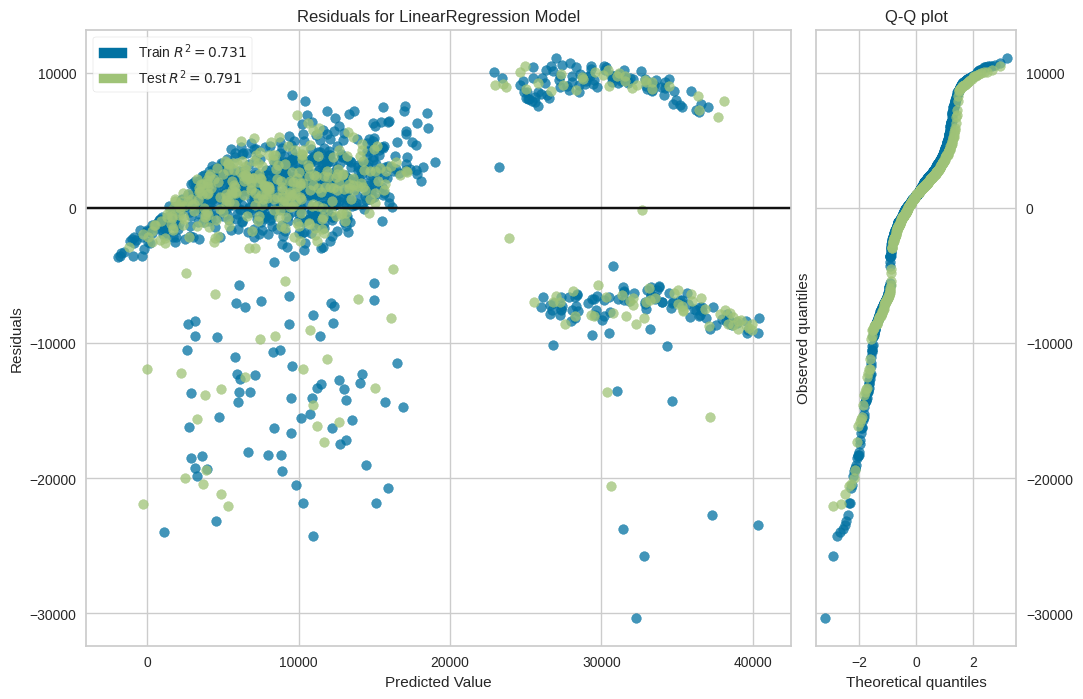

In [21]:
from yellowbrick.regressor import residuals_plot
plt.figure(figsize=(12,8))
viz = residuals_plot(lr, X_train_encoded, y_train, X_test_encoded, y_test, is_fitted=True, qqplot=True, hist=False)


El gráfico anterior muestra el análisis de residuos generado por Yellowbrick para el modelo de regresión lineal previo, con dos gráficos principales. En el gráfico de la izquierda podemos ver los residuos vs los valores predichos, en este se aprecia que los residuos se distribuyen alrededor de la línea horizontal (residuo = 0), pero se observan patrones claros, agrupandose la mayoria de puntos en la zona de valores predichos bajos y altos. El gráfico de la derecha representa la normalidad de los residuos,
Compara los cuantiles observados vs los teóricos de una distribución normal. Podemos observar que los puntos se desvían considerablemente de la línea diagonal, especialmente en los extremos, lo que indica que los residuos NO siguen una distribución normal.


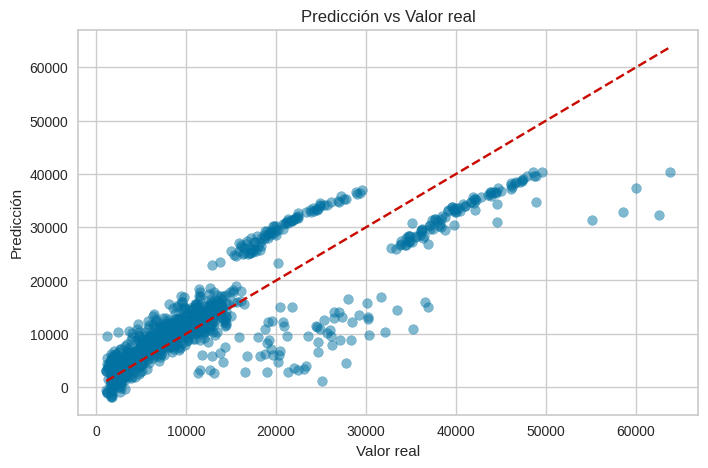

In [22]:
plt.figure(figsize=(8,5))
plt.scatter(y_train, y_pred_train, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.xlabel("Valor real")
plt.ylabel("Predicción")
plt.title("Predicción vs Valor real")
plt.show()

Muestra en el eje X los valores reales y en el eje Y las predicciones del modelo. La línea roja punteada representa la predicción perfecta (diagonal).
La mayoría de los puntos están cerca de la diagonal, lo que indica que para muchos ejemplos el modelo predice correctamente.
Sin embargo, para valores reales altos, el modelo tiende a subestimar (los puntos están por debajo de la diagonal).

In [23]:
import statsmodels.api as sm

X_train_sm = sm.add_constant(X_train_encoded.astype(float))
model = sm.OLS(y_train, X_train_sm)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     314.8
Date:                Sun, 19 Oct 2025   Prob (F-statistic):          3.47e-258
Time:                        19:34:47   Log-Likelihood:                -9495.3
No. Observations:                 936   AIC:                         1.901e+04
Df Residuals:                     927   BIC:                         1.905e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.184e+04   1205.932  

Las variables age, bmi, children y smoker_yes son significativas ya que tienen un p < 0.05. En particular, el coeficiente asociado a "smoker_yes" es muy alto y significativo, lo que refleja el fuerte impacto que tiene el hecho de ser fumador en el coste.
Las variables sex_male, region_northwest, region_southeast y region_southwest tienen un p > 0.05 y no son significativas, lo que indica que su influencia para la variable objetivo no es relevante.

In [24]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# 1. Primero normaliza
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# 2. Luego aplica PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

In [25]:
from sklearn.linear_model import LinearRegression

lr_poly = LinearRegression()
lr_poly.fit(X_train_poly, y_train)

y_pred_train_poly = lr_poly.predict(X_train_poly)
y_pred_test_poly = lr_poly.predict(X_test_poly)

In [26]:
from sklearn.metrics import mean_absolute_error, r2_score

print("Regresión lineal simple:")
print("R² (train):", r2_score(y_train, y_pred_train))
print("MAE (train):", mean_absolute_error(y_train, y_pred_train))

print("\nRegresión polinómica grado 2:")
print("R² (train):", r2_score(y_train, y_pred_train_poly))
print("MAE (train):", mean_absolute_error(y_train, y_pred_train_poly))


Regresión lineal simple:
R² (train): 0.7309569871174701
MAE (train): 4246.66101891283

Regresión polinómica grado 2:
R² (train): 0.8323036814554396
MAE (train): 2964.1378539146995


Tras añadir características polinómicas de grado 2 con PolynomialFeatures, el modelo de regresión lineal ajustado a estos nuevos datos muestra un R² superior al del modelo lineal original en el conjunto de entrenamiento, lo que indica que es capaz de capturar relaciones no lineales entre las variables independientes y la variable objetivo.
Además, el error absoluto medio (MAE) disminuye de 4,247 a 2,964, mostrando que las predicciones son más precisas en promedio. Esto confirma que existen relaciones no lineales entre las variables del conjunto de datos y la variable objetivo, y que el modelo polinómico es capaz de capturarlas mejor que la regresión lineal simple.

In [27]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, r2_score

lasso = Lasso(alpha=1.0, max_iter=10000)
lasso.fit(X_train_poly, y_train)

y_pred_train_lasso = lasso.predict(X_train_poly)

print("Regresión LASSO polinómica grado 2:")
print("R² (train):", r2_score(y_train, y_pred_train_lasso))
print("MAE (train):", mean_absolute_error(y_train, y_pred_train_lasso))


n_zeros = sum(lasso.coef_ == 0)
print(f"Número de variables eliminadas (coeficiente=0): {n_zeros} de {len(lasso.coef_)}")

Regresión LASSO polinómica grado 2:
R² (train): 0.8323031746144116
MAE (train): 2963.9910896235874
Número de variables eliminadas (coeficiente=0): 7 de 44


Tras aplicar características polinómicas de grado 2 y ajustar un modelo LASSO, se observa que el R² se mantiene en 0.832, similar al modelo polinómico sin regularización, pero con la ventaja de que LASSO elimina 7 de las 44 variables generadas, simplificando significativamente el modelo. El MAE también se mantiene prácticamente igual (2964), lo que indica que la selección automática de variables no compromete la capacidad predictiva. Esto demuestra que muchas de las interacciones polinómicas generadas no aportan información relevante y pueden eliminarse sin pérdida de rendimiento.

In [28]:
import pandas as pd

feature_names = poly.get_feature_names_out(X_train_encoded.columns)
lasso_weights = pd.DataFrame({
    'feature': feature_names,
    'coef': lasso.coef_
})

lasso_weights['abs_coef'] = lasso_weights['coef'].abs()
lasso_weights_sorted = lasso_weights.sort_values('abs_coef', ascending=False)
print(lasso_weights_sorted.head(10))

                              feature         coef     abs_coef
4                          smoker_yes  7769.150877  7769.150877
0                                 age  3757.134276  3757.134276
19                     bmi smoker_yes  3635.078903  3635.078903
1                                 bmi  2093.352461  2093.352461
34                       smoker_yes^2  1288.643522  1288.643522
42  region_southeast region_southwest   969.599552   969.599552
2                            children   893.533749   893.533749
8                               age^2   546.931649   546.931649
21               bmi region_southeast  -392.786708   392.786708
14               age region_southeast   390.972356   390.972356


El modelo LASSO mantiene prácticamente la misma capacidad predictiva que la regresión polinómica sin regularización, pero con la ventaja de la selección automática de variables. Ambos modelos polinómicos superan significativamente al modelo lineal simple.

Al analizar los diferentes pesos vemos la importancia de cada variable. Así pues podemos observar que la variable smoker_yes es la más influyente con diferencia teniendo un coeficiente de 7769.15. Por lo contrario, la menos influyente sería  age region_southeast  con un 390.97 de coeficiente.

Las interacciones identificadas por LASSO revelan que los factores de riesgo no actúan de forma independiente. La interacción más relevante (bmi smoker_yes) demuestra que el sobrepeso en fumadores genera un coste adicional. Las interacciones regionales sugieren que los costes médicos varían según la ubicación geográfica.

Podemos concluir que las interacciones entre variables son fundamentales para explicar bien los costes de seguros médicos.
